In [29]:
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import chain
import matplotlib.pyplot as plt
import time

In [2]:
#Lectura del archivo .npy
db = np.load('spotify.npy')[()]

In [3]:
#Listas de reproduccion almacendas en diccionario
db = {x: set(db[x]) for x in db}

In [4]:
def initial_count(db):
    '''
    Realiza conteo inicial, de cada cancion en todas las listas.
    '''
    dict_count = defaultdict(int)
    for key in db:
        for value in db[key]:
            dict_count[tuple([value])] += 1
    return dict_count

In [9]:
initial = initial_count(db)
print(initial)

defaultdict(<class 'int'>, {('Beautiful Soul',): 97, ('See You Again',): 103, ('Buttons',): 68, ('Everytime We Touch - Radio Edit',): 83, ('Yeah!',): 238, ('Replay',): 149, ('Just The Girl',): 22, ('Right Where You Want Me - Radio Edit Version',): 9, ('Paper Planes',): 138, ('Promiscuous',): 160, ('Crazy In Love',): 190, ('Soak Up The Sun',): 19, ('Whatcha Say',): 116, ('Livin on Sunday',): 2, ('Run It!',): 65, ('My Happy Ending',): 17, ('All The Small Things',): 165, ('Somebody To Love',): 41, ('How Do You Sleep? - Featuring Ludacris',): 19, ('Beep',): 7, ('Hey Ya! - Radio Mix / Club Mix',): 203, ("Jumpin', Jumpin'",): 56, ('Ice Box',): 19, ('Check Yes Juliet',): 57, ('A Thousand Miles',): 99, ('Say My Name',): 266, ('My Boo',): 92, ('Where Is The Love?',): 100, ('Miss Independent',): 118, ('The Great Escape',): 56, ('Me & U',): 64, ('Baby',): 94, ('Year 3000',): 74, ('Toxic',): 125, ("Leavin'",): 44, ('Yo (Excuse Me Miss)',): 50, ('Rock Your Body',): 87, ("Stacy's Mom",): 126, ('Sk8e

In [5]:
def remove_itemsets(dict_count, min_sup_count):
    '''
    Elimina del diccionario los itemsets que no cumplen con el umbral de
    soporte.
    '''
    new_dict = {x: y for (x, y) in dict_count.items() if y >= min_sup_count}
    return new_dict

In [6]:
def make_combinations(groups, size, initial_order):
    '''
    Realiza las combinaciones de itemsets segun un orden.
    '''
    i = 0
    j = 1
    k = (size - 2)
    new_itemsets = list()
    
    while i < len(groups):

        next_item = False
        while j < len(groups) and not next_item:
            accepted = True
            if size != 2:
                for m in range(k):
                    if groups[i][m] != groups[j][m]:
                        accepted = False
                        next_item = True
            if groups[i][-1] == groups[j][-1]:
                accepted = False

            if accepted:
                new_itemsets.append(tuple(sorted(set(groups[i] + groups[j]), key=lambda x: initial_order.index(x))))

            j += 1

        i += 1
        j = i + 1
        
    return new_itemsets

In [8]:
def fit(db, initial, min_sup_count):
    '''
    Aplica el algoritmo apriori.
    Retorna los itemsets de mayor tamaño, que cumplan con el umbral de soporte.
    '''
    size = 2
    dict_count = remove_itemsets(initial, min_sup_count)
    initial_order = sorted([x[0] for x in dict_count], key=lambda x: dict_count[(x,)], reverse=True)
    itemsets = [(x,) for x in initial_order]
    itemsets = make_combinations(itemsets, size, initial_order)
    
    current_dict = dict()
    while itemsets:
         
        dict_count = defaultdict(int)
        
        for itemset in itemsets:
            
            i = set(itemset)
            count = 0
            for column in db:
                if i.issubset(db[column]):
                    count += 1
            dict_count[itemset] += count
                    
        size+=1
        
        dict_count = remove_itemsets(dict_count, min_sup_count)
        if len(dict_count) > 0:
            current_dict = dict_count
        itemsets = [x for x in itemsets if x in dict_count]
        itemsets = make_combinations(itemsets, size, initial_order)
        
    current_dict = {frozenset(x): current_dict[x] for x in current_dict}
        
    return current_dict

In [258]:
time_a = time.time()
frequent_itemsets1 = fit(db, initial, 120)
time_b = time.time()
print("Tiempo de Ejecucion", time_b-time_a, "segundos")
print("Itemsets Frecuentes -> min_sup_count: 120")
for i, j in enumerate(frequent_itemsets1):
    print(str(i)+".", "{"+('{}, '*len(j)).format(*j).strip(', ')+"} :", frequent_itemsets1[j])

Tiempo de Ejecucion 315.20295810699463 segundos
Itemsets Frecuentes -> min_sup_count: 120
0. {XO TOUR Llif3, HUMBLE., Congratulations} : 128
1. {Mask Off, HUMBLE., Congratulations} : 121
2. {XO TOUR Llif3, HUMBLE., Mask Off} : 131


In [259]:
time_a = time.time()
frequent_itemsets2 = fit(db, initial, 80)
time_b = time.time()
print("Tiempo de Ejecucion", time_b-time_a, "segundos")
print("Itemsets Frecuentes -> min_sup_count: 80")
for i, j in enumerate(frequent_itemsets2):
     print(str(i)+".", "{"+('{}, '*len(j)).format(*j).strip(', ')+"} :", frequent_itemsets2[j])

Tiempo de Ejecucion 1430.1741099357605 segundos
Itemsets Frecuentes -> min_sup_count: 80
0. {XO TOUR Llif3, HUMBLE., Mask Off, Congratulations} : 86
1. {XO TOUR Llif3, HUMBLE., Congratulations, goosebumps} : 80
2. {XO TOUR Llif3, HUMBLE., Mask Off, goosebumps} : 85


In [11]:
def find_support(db, x):
    '''
    Encuentra el soporte de un itemset en especifico
    '''
    support = 0
    for column in db:
        if x.issubset(db[column]):
            support += 1
    return support

In [288]:
def generate(db, initial, frequent_itemsets, support, confidence):
    '''
    Genera las reglas de asociacion segun distintos criterios, a partir de 
    los itemsets frecuentes.
    '''
    length_db = len(db)
    
    rules = list()
    for itemset in frequent_itemsets:
        itemset = [tuple([x]) for x in itemset]
        size = 2
        length = len(itemset)
        initial_order = sorted([x[0] for x in itemset], key=lambda x: initial[(x,)], reverse=True)
        groups = list()
        while size <= length:
            c = sorted(make_combinations(itemset, size, initial_order), key=lambda x: x[:len(x)-1])
            itemset = c      
            groups.append(c)
            size += 1
        
        for m in range(len(groups)):

            if m == 0:
                for g in groups[m]:
                    r1 = [[g[0]], [g[1]]]
                    r2 = [[g[1]], [g[0]]]
                    if r1 not in rules:
                        rules.append(r1)
                    if r2 not in rules:
                        rules.append(r2)
                        
            else:
                for g in groups[m-1]:
                    
                    for item in initial_order:
                        
                        if item not in g:
                            r1 = [list(g), [item]]
                            r2 = [[item], list(g)]
                            if r1 not in rules:
                                rules.append(r1)
                            if r2 not in rules:
                                rules.append(r2)
                            
        
    info = list()
    for rule in rules:
        x_support = find_support(db, set(rule[0]))/length_db
        y_support = find_support(db, set(rule[1]))/length_db
        
        rule_str = ", ".join(rule[0]) + " -> " + ",".join(rule[1])
    
        support_db = find_support(db, set(x for x in chain(rule[0], rule[1])))/length_db
        confidence = support_db / x_support
        lift = support_db / (x_support * y_support)
        
        info.append((rule_str, support_db, confidence, lift))

    
    
    info = list(filter(lambda x: x[2] >= confidence and x[1] >= support, info))
    info = sorted(info, key=lambda x: (x[2], x[3]), reverse=True)
    return list(zip(*info[:10]))

In [304]:
info1 = generate(db, initial, frequent_itemsets1, 0.0012,0.5)

d1 = {'Rule': info1[0], 'Support': info1[1], 'Confidence': info1[2], 'Lift': info1[3]}
df1 = pd.DataFrame(data=d1)
df1

Confidence       Lift                                       Rule  Support
0    0.803681  17.283462         XO TOUR Llif3, Mask Off -> HUMBLE.   0.0131
1    0.746914  16.062658       Congratulations, Mask Off -> HUMBLE.   0.0121
2    0.715084  15.378146  Congratulations, XO TOUR Llif3 -> HUMBLE.   0.0128
3    0.645570  13.883218                        Mask Off -> HUMBLE.   0.0204
4    0.642157  20.321420         HUMBLE., XO TOUR Llif3 -> Mask Off   0.0131
5    0.642157  19.881017         HUMBLE., Mask Off -> XO TOUR Llif3   0.0131
6    0.631579  13.582343                   XO TOUR Llif3 -> HUMBLE.   0.0204
7    0.627451  15.569503  HUMBLE., XO TOUR Llif3 -> Congratulations   0.0128
8    0.598131  18.517983  HUMBLE., Congratulations -> XO TOUR Llif3   0.0128
9    0.593137  14.718046       HUMBLE., Mask Off -> Congratulations   0.0121

In [305]:
info2 = generate(db, initial, frequent_itemsets2, 0.004,0.7)
d2 = {'Rule': info2[0], 'Support': info2[1], 'Confidence': info2[2], 'Lift': info2[3]}
df2 = pd.DataFrame(data=d2)
df2

Confidence       Lift                                               Rule  \
0    0.841584  18.098584     XO TOUR Llif3, Mask Off, goosebumps -> HUMBLE.   
1    0.803738  17.284695  Congratulations, XO TOUR Llif3, Mask Off -> HU...   
2    0.803681  17.283462                 XO TOUR Llif3, Mask Off -> HUMBLE.   
3    0.772727  23.923445     HUMBLE., Mask Off, goosebumps -> XO TOUR Llif3   
4    0.769231  16.542597  Congratulations, XO TOUR Llif3, goosebumps -> ...   
5    0.765766  24.233094     HUMBLE., XO TOUR Llif3, goosebumps -> Mask Off   
6    0.746914  16.062658               Congratulations, Mask Off -> HUMBLE.   
7    0.743243  15.983726                    Mask Off, goosebumps -> HUMBLE.   
8    0.730263  15.704584               XO TOUR Llif3, goosebumps -> HUMBLE.   
9    0.722581  15.539369             Congratulations, goosebumps -> HUMBLE.   

   Support  
0   0.0085  
1   0.0086  
2   0.0131  
3   0.0085  
4   0.0080  
5   0.0085  
6   0.0121  
7   0.0110  
8   0.0111  
9   0.0112

In [301]:
def make_graph(info):
    '''
    Genera una representacion grafica de las reglas de asociacion.
    '''
    plt.figure(figsize=(15,10))
    for r in range(len(info[0])):
        plt.scatter(info[1][r], info[2][r], s=(info[3][r]+5)*10)


    plt.legend(info[0], loc='upper right', ncol=1)
    plt.title("Reglas de Asociacion")
    plt.xlabel("Support")
    plt.ylabel("Confidence")

    plt.show()


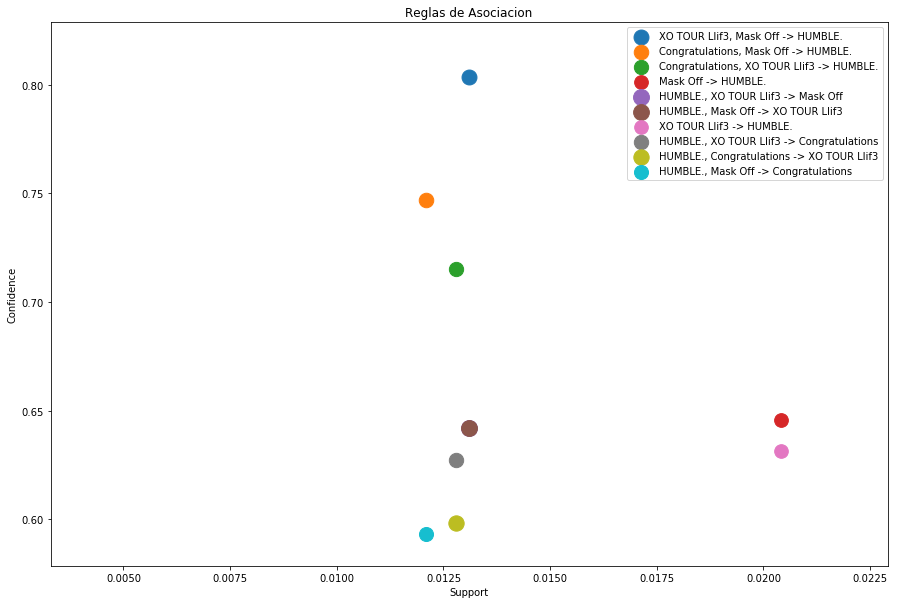

In [306]:
make_graph(info1)

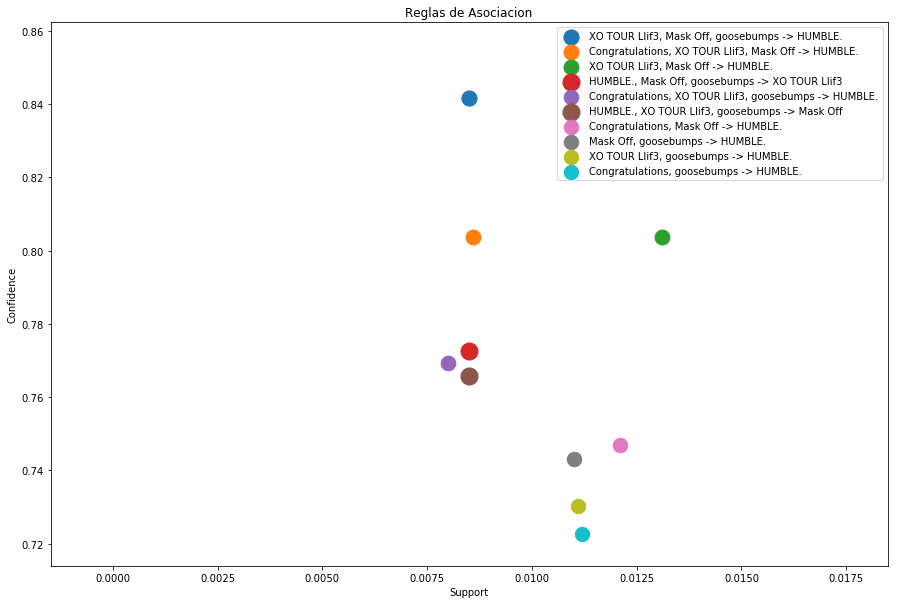

In [307]:
make_graph(info2)